In [1]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coords
import astropy.time
import astropy.cosmology as cosmo
from astropy.visualization import astropy_mpl_style, quantity_support
import pandas as pd
import get_vlass

import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
%matplotlib inline

# Ofek catalog

Ofek (2017) identified a sample of ~100 FIRST sources aligned with nearby galaxies and luminosities comparable to the persistent radio source at FRB 121102. 11 of these were not nuclear, so are less likely to be AGN. Chance of true association is high for most of the sample of 11 sources.

Ofek catalog: http://cdsarc.u-strasbg.fr/viz-bin/nph-Cat/html?J%2FApJ%2F846%2F44/table1.dat

Below, we search for VLASS counterparts to all of the Ofek catalog.

In [2]:
ofektab = pd.read_table('ofek_table1.txt', delim_whitespace=True,
                            na_filter=False, comment='#', index_col=False,
                            names=['ra0', 'ra1', 'ra2', 'dec0', 'dec1', 'dec2',
                                   'Sf', 'eSf', 'L', 'z', 'offset'])

# First 11 sources are "interesting"
ofektab.head(11)

,ra0,ra1,ra2,dec0,dec1,dec2,Sf,eSf,L,z,offset
0,9,27,58.282,-2,25,58.95,2.1,0.14,0.14,0.023,14.32
1,10,47,26.693,6,2,47.72,2.9,0.14,0.13,0.019,5.87
2,23,53,51.412,7,58,35.91,4.2,0.13,0.16,0.018,42.68
3,14,10,43.667,8,59,29.96,3.2,0.15,0.21,0.023,17.66
4,10,25,26.189,17,15,47.97,2.8,0.13,0.11,0.018,7.08
5,10,58,23.641,24,13,55.32,2.3,0.15,0.12,0.021,29.79
6,13,14,41.932,29,59,59.19,2.2,0.14,0.14,0.023,20.58
7,16,22,44.571,32,12,59.28,2.0,0.15,0.11,0.022,0.89
8,14,0,38.929,-2,51,22.79,1.5,0.15,0.11,0.025,26.41
9,11,45,29.346,19,23,27.46,3.5,0.20,0.26,0.025,33.35


In [3]:
def jname(i):
    row = ofektab.iloc[i]
    return "J{0:02d}{1:02d}{2:.3f}{3:+03d}{4:02d}{5:.2f}".format(int(row.ra0), int(row.ra1), row.ra2, int(row.dec0), int(row.dec1), row.dec2)
    
def getcoord(i):    
    row = ofektab.iloc[i]
    co = coords.SkyCoord((row.ra0, row.ra1, row.ra2),
                            (row.dec0, row.dec1, row.dec2),
                            unit=(u.hour, u.deg))
    return co

def printsrc(i):
    try:
        filename = get_vlass.get_filename(getcoord(i))
        print('\t{0}'.format(filename))
    except FileNotFoundError:
        print('\tNo file found')
    return jname(i)

In [4]:
sources_no_coverage = [3, 4, 5, 8, 9]

In [5]:
i=0
name = printsrc(i)
s0 = 1.54*u.milliJansky
es0 = 0.16*u.milliJansky
s0_first = ofektab.iloc[i].Sf*u.milliJansky
es0_first = ofektab.iloc[i].eSf*u.milliJansky

print('Source {0}:{1} detected'.format(i, name))
print('\talpha={0}'.format(np.log(s0/s0_first)/np.log(3/1.4)))

Found a file VLASS1.1.ql.T10t15.J092600-023000.10.2048.v2 offset by 0.4969169377804662 deg
	VLASS1.1.ql.T10t15.J092600-023000.10.2048.v2
Source 0:J092758.282-022558.95 detected
	alpha=-0.4069526689626789


In [6]:
i=1
name = printsrc(i)
s1 = 1.08*u.milliJansky
es1 = 0.16*u.milliJansky
s1_first = ofektab.iloc[i].Sf*u.milliJansky
es1_first = ofektab.iloc[i].eSf*u.milliJansky
print('Source {0}:{1} detected'.format(i, name))
print('\talpha={0}'.format(np.log(s1/s1_first)/np.log(3/1.4)))

Found a file VLASS1.1.ql.T12t17.J104601+063000.10.2048.v1 offset by 0.5758006642656701 deg
	VLASS1.1.ql.T12t17.J104601+063000.10.2048.v1
Source 1:J104726.693+060247.72 detected
	alpha=-1.296021240720099


In [7]:
i=2
name = printsrc(i)
s2 = 3.19*u.milliJansky
es2 = 0.12*u.milliJansky
s2_first = ofektab.iloc[i].Sf*u.milliJansky
es2_first = ofektab.iloc[i].eSf*u.milliJansky
print('Source {0}:{1} detected'.format(i, name))
print('\talpha={0}'.format(np.log(s2/s2_first)/np.log(3/1.4)))

Found a file VLASS1.1.ql.T12t36.J235415+073000.10.2048.v1 offset by 0.4864891593536252 deg
	VLASS1.1.ql.T12t36.J235415+073000.10.2048.v1
Source 2:J235351.412+075835.91 detected
	alpha=-0.36090953067461146


In [8]:
i=6
name = printsrc(i)
s6 = 1.83*u.milliJansky
es6 = 0.11*u.milliJansky
s6_first = ofektab.iloc[i].Sf*u.milliJansky
es6_first = ofektab.iloc[i].eSf*u.milliJansky
print('Source {0}:{1} detected'.format(i, name))
print('\talpha={0}'.format(np.log(s6/s6_first)/np.log(3/1.4)))

Found a file VLASS1.1.ql.T18t18.J131443+293000.10.2048.v1 offset by 0.4997899328571194 deg
	VLASS1.1.ql.T18t18.J131443+293000.10.2048.v1
Source 6:J131441.932+295959.19 detected
	alpha=-0.24161096509281718


In [9]:
i=7
name = printsrc(i)
s7 = 1.23*u.milliJansky
es7 = 0.11*u.milliJansky
s7_first = ofektab.iloc[i].Sf*u.milliJansky
es7_first = ofektab.iloc[i].eSf*u.milliJansky
print('Source {0}:{1} detected'.format(i, name))
print('\talpha={0}'.format(np.log(s7/s7_first)/np.log(3/1.4)))

Found a file VLASS1.1.ql.T19t21.J162113+323000.10.2048.v1 offset by 0.42926338858878216 deg
	VLASS1.1.ql.T19t21.J162113+323000.10.2048.v1
Source 7:J162244.571+321259.28 detected
	alpha=-0.6378525966060973


Five sources have no VLASS coverage.

Five of the six with VLASS coverage have a compact radio source at the location of the Ofek/FIRST source. The flux of those VLASS 3 GHz sources is systematically less than that of FIRST with implied L/S spectral index of -0.2 to -1.2 (assuming no variability).

One of the "interesting" sources is *really* interesting.

# J141918.855+394036.03

## Optical counterpart

FIRST source is offset 0.5" from center of z=0.01957 dwarf galaxy.

Pretty picture: http://legacysurvey.org/viewer-dev/?ra=214.828550&dec=39.676672

Image and spectrum from SDSS:
http://skyserver.sdss.org/dr14/en/tools/quicklook/summary.aspx?ra=214.82854&dec=39.6768

SDSS photometry:
- Ultraviolet (u):	19.34 ± 0.04
- Green (g):	18.62 ± 0.01
- Red (r):	18.70 ± 0.02
- Infrared - 7600 Å (i):	18.83 ± 0.02
- Infrared - 9100 Å (z):	18.95 ± 0.10

For distance modulus of 34.7 mag, the absolute r band magnitude is -16 mag.

Paper on IR/radio sample of galaxies. Our galaxy is the only one with z<2, which makes it wildly out of place: http://adsabs.harvard.edu/abs/2014MNRAS.439..545C

Pan-STARRS source "PSO J141918.804+394035.996":
- Many detections across all bands.
- Stacked location 14:19:18.805, +39:40:36.00
- Half a magnitude fainter than SDSS in all bands. Why?

Also covered by DESI DR6: http://legacysurvey.org/dr6/files/

## VLASS

In [10]:
t_first = 1994.63 # listed in catalog
f_first = 1.40 # gigahertz
#s_first = 21.1 # millijansky; catalog
#es_first = 0.16 # millijansky; catalog
s_first = 20.77 # millijansky; aegean peak
es_first = 0.17 # millijansky; aegean

t_nvss = 1995.32 # project AC0308 observed late-april/early-may
f_nvss = 1.40
#s_nvss = 18.5  # mjy; catalog
#es_nvss = 1.0  # mjy; catalog
s_nvss = 16.10  # mjy; aegean peak
es_nvss = 0.51  # mjy; aegean peak

t_vlass = 2017.78 # listed in pipeline log
s_vlass = 3*0.122  # 3sigma measured on fits image
f_vlass = 3.0

## Farnes polarimetry project (15A-033)
S-band data observed 2015-May-11 and prepared Jamie Farnes.
Observations at L and S bands.
Image dominated by bright, complex source at phase center, so some residual noise.

In [31]:
t_farnes = astropy.time.Time('2015-05-11').decimalyear
f_farnesS = 3.  # GHz
s_farnesS = 0.7   # detection! Jamie's "wide" image with pbcor. 0.25 mJy in my image before pbcor
es_farnesS = 0.05
f_farnesL = 1.52  # GHz
s_farnesL = 1.12  # mJy; detection! no pbcor
es_farnesL = 0.1
alpha_farnesLS = np.log(s_farnesL/s_farnesS)/np.log(f_farnesL/f_farnesS)
ealpha_farnesLS = (es_farnesL/s_farnesL**2) + (es_farnesS/s_farnesS**2)
# point-like; 2d Gaussian fit to L-band source does not resolve it

# spectral index estimate within L band
f_farnesL_bottom = 1.3  # GHz
s_farnesL_bottom = 1.45  # mjy; casa 2d gaussian fit
es_farnesL_bottom = 0.15  # mjy; casa 2d gaussian fit
f_farnesL_top = 1.8  # Ghz
s_farnesL_top = 0.87  # mjy; casa 2d gaussian fit
es_farnesL_top = 0.11  # mjy; casa 2d gaussian fit
alpha_farnesLL = np.log(s_farnesL_bottom/s_farnesL_top)/np.log(f_farnesL_bottom/f_farnesL_top)
ealpha_farnesLL = (es_farnesL_top/s_farnesL_top**2) + (es_farnesL_bottom/s_farnesL_bottom**2)

# spectral index estimate within S band
f_farnesS_bottom = 2.5  # GHz
s_farnesS_bottom = 0.79  # mjy; casa 2d gaussian fit
es_farnesS_bottom = 0.11  # mjy; casa 2d gaussian fit
f_farnesS_top = 3.5  # GHz
s_farnesS_top = 0.833  # mjy; casa 2d gaussian fit
es_farnesS_top = 0.13  # mjy; casa 2d gaussian fit
alpha_farnesSS = np.log(s_farnesS_bottom/s_farnesS_top)/np.log(f_farnesS_bottom/f_farnesS_top)
ealpha_farnesSS = (es_farnesS_top/s_farnesS_top**2) + (es_farnesS_bottom/s_farnesS_bottom**2)

print('Late-time spectral index:')
print('\t{0}+-{1} (L/S; pb issues)'.format(alpha_farnesLS, ealpha_farnesLS))
print('\t{0}+-{1} (Ltop/Lbottom)'.format(alpha_farnesLL, ealpha_farnesLL))
print('\t{0}+-{1} (Stop/Sbottom)'.format(alpha_farnesSS, ealpha_farnesSS))

Late-time spectral index:
	-0.6912814805311346+-0.18176020408163268 (L/S; pb issues)
	-1.5697309806692519+-0.21667327255912272 (Ltop/Lbottom)
	0.1575187814542974+-0.3636036553838382 (Stop/Sbottom)


## Archival VLA L-band (AB6860) 

In [12]:
t_ab6860 = astropy.time.Time('1993-11-13').decimalyear
f_ab6860 = 1.465  # GHz

"""
s_ab6860_obs = 17  # mJy detection on image (before flux scale applied)
es_ab6860_obs = 0.5 # statistical uncertainty from image (before flux scale)

# selfcal by comparing to nvss
s6860 = np.array([187, 98, 18, 278, 20])
snvss = np.array([205, 116, 36, 374, 27])
print('NVSS/AB6860 flux ratios: {0}'.format(snvss/s6860))
s_ab6860 = snvss.mean()/s6860.mean()*s_ab6860_obs
es_ab6860 = snvss.mean()/s6860.mean()*es_ab6860_obs * 0.1*s_ab6860  # add 10% of flux as systematic uncertainty
print('scaled source flux: {0:.2f} +- {1:.2f}'.format(s_ab6860, es_ab6860))
"""

print('Potential spec index bias relative to FIRST/NVSS: {0:.2f}%'.format(1-(f_ab6860/f_nvss)**-0.7))

# force values to this for now based on Bryan's analysis
s_ab6860 = 20.
es_ab6860 = 3.  # quadrature sum of stat and sys errors from various methods
# TODO: ab6860 has P band data with limit near 3sigma*30 mJy
f_ab6860P = 0.325  # guess
#s_ab6860P = 45  # mJy; 3 sigma limit from Bryan's first pass
s_ab6860P = 58*3  # mJy; 3 sigma limit # Rick's analysis assumes 1358+624 == 10 Jy at P
alpha_ab6860 = np.log10(s_ab6860/s_ab6860P)/np.log10(f_ab6860/f_ab6860P)

# TODO: add estimate of systematic flux uncertainty

Potential spec index bias relative to FIRST/NVSS: 0.03%


## Archival WSRT L-band (ATLAS-3D)

In [13]:
times = ['2008-07-18', '2010-07-14', '2010-07-21', '2010-07-28',
         '2010-08-04', '2010-08-05', '2010-08-13', '2010-09-17',
         '2010-10-17', '2010-10-30']
t_atlas = [astropy.time.Time(tt).decimalyear for tt in times]
f_atlas = 1420.  # MHz
s_atlas = [2.5, 2.1, 1.9, 1.9, 1.4, 1.3, 1.5, 1.6, 1.8, 1.9]  # mJy; peak
es_atlas = [0.1]*10  # statistical; TODO: consider systematic

In [14]:
# peak flux
# source 0, near 14:18:51.48  +39:44:25.58, outside j1419 
# 4.1 mJy in FIRST, 4.1 mJy in NVSS
s_atlas_ref0 = [0.003219, 0.003383, 0.003152, 0.004070, 0.004415, 0.003036, 0.003942, 0.004381, 0.004058, 0.003445]
es_atlas_ref0 = [0.000196, 0.000286, 0.000176, 0.000206, 0.000210, 0.000199, 0.000210, 0.000206, 0.000178, 0.000175]
# source 1, near 14:20:06.34  +39:35:03.30, inside j1419
# 3 mJy in FIRST, 10 mJy in NVSS
s_atlas_ref1 = [0.007826, 0.008621, 0.007838, 0.008036, 0.007630, 0.007718, 0.007869, 0.007774, 0.007653, 0.007843]
es_atlas_ref1 = [0.000086, 0.000121, 0.000082, 0.000107, 0.000100, 0.000105, 0.000099,  0.000094, 0.000084, 0.000078]

# integrated flux
#s_atlas_ref0 = [0.004648, 0.007208, 0.004246, 0.005711, 0.005975, 0.004799, 0.006187, 0.006000, 0.005622, 0.004654]
#es_atlas_ref0 = [0.000330, 0.000735, 0.000277, 0.000336, 0.000330, 0.000369, 0.000385, 0.000330, 0.000288, 0.000275]
# source 1, near 14:20:06.34  +39:35:03.30, inside j1419
#s_atlas_ref1 = [0.011440, 0.019431, 0.011554, 0.011678, 0.010822, 0.011715, 0.011411, 0.011118, 0.011160, 0.011266]
#es_atlas_ref1 = [0.000145, 0.000317, 0.000140, 0.000180, 0.000165, 0.000185, 0.000167, 0.000156, 0.000142, 0.000131]

es_sys_ref0 = np.std(s_atlas_ref0)
es_sys_ref1 = np.std(s_atlas_ref1)

print("Reference source std: {0} Jy, {1} Jy".format(es_sys_ref0, es_sys_ref1))

Reference source std: 0.0004935249639076021 Jy, 0.00027038668606275723 Jy


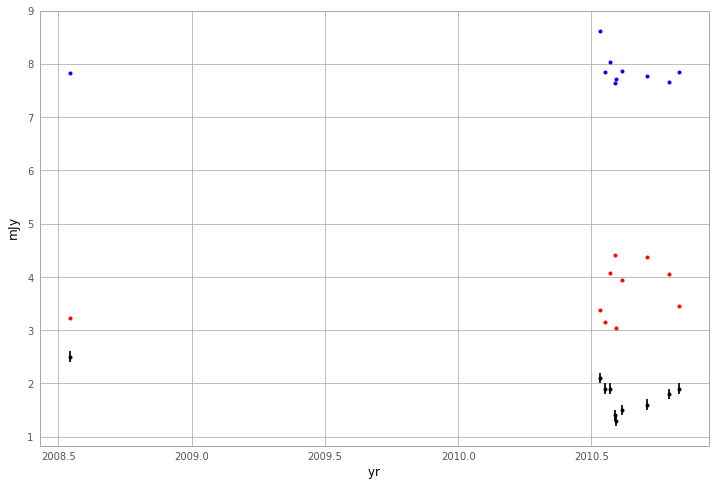

In [15]:
with quantity_support():
    fig = plt.figure(figsize=(12,8))
    plt.errorbar(t_atlas*u.year, s_atlas*u.milliJansky, yerr=es_atlas*u.milliJansky, fmt='k.')
    plt.errorbar(t_atlas*u.year, s_atlas_ref0*u.Jansky, yerr=es_atlas_ref0*u.milliJansky, fmt='r.')
    plt.errorbar(t_atlas*u.year, s_atlas_ref1*u.Jansky, yerr=es_atlas_ref1*u.milliJansky, fmt='b.')

In [16]:
# redefine atlas error to include estimated systematic value added in quadrature
es_atlas = [np.sqrt(0.1**2 + (1e3*es_sys_ref0)**2)]*10

#### Spectral index limits

In [17]:
alpha_fv = np.log10(s_first/s_vlass)/np.log10(f_first/f_vlass)
alpha_ffL = np.log10(s_first/s_farnesS)/np.log10(f_first/f_farnesS)

print("Upper limit from non-simultaneous 1.4 to 3 GHz spectral index: {0} and {1}".format(alpha_fv, alpha_ffL))
print("Lower limit from simultaneous 0.325 to 1.4 GHz spectral index: {0}".format(alpha_ab6860))

Upper limit from non-simultaneous 1.4 to 3 GHz spectral index: -5.299067504223334 and -4.448243564580627
Lower limit from simultaneous 0.325 to 1.4 GHz spectral index: -1.436674251937369


#### ATA nondetection

In [18]:
# atats survey
t_ata = astropy.time.Time('2009-02-15').decimalyear  # epochs from jan - april
f_ata = 1.43  # GHz
s_ata = 12  # mJy; 3sigma limit

#### Low-frequency non-detections
* 74 MHz from VLSSr: https://heasarc.gsfc.nasa.gov/W3Browse/radio-catalog/vlssr.html
* 150 MHz from TGSS: http://tgssadr.strw.leidenuniv.nl/doku.php?id=spidx
* 325 MHz from WENSS: https://heasarc.gsfc.nasa.gov/w3browse/all/wenss.html

In [19]:
t_vlssr = astropy.time.Time('2005-03-14').decimalyear
f_vlssr = 74e-3
s_vlssr = 3*130   # mJy; nominal 3 sigma limit

t_tgss = astropy.time.Time('2011-04-16').decimalyear
f_tgss = 150e-3  # GHz
s_tgss = 3*10.  # mJy; nominal 3 sigma limit

t_wenss = astropy.time.Time('1994-04-25').decimalyear  # 1994-03-28 to 1994-05-22
f_wenss = 325e-3  # GHz
s_wenss = 11 # mJy; nominal 3 sigma limit (5 sigma is quoted limit)

alpha_fw = np.log10(s_first/s_wenss)/np.log10(f_first/f_wenss)
print('Lower limit from non-simultaneous 0.325/1.4 GHz: {0}'.format(alpha_fw))

Lower limit from non-simultaneous 0.325/1.4 GHz: 0.43523236755234995


Other potential data sets to analyze:
* ~~VLA AS0249 (L-band, A-config, 86-Apr-11) -- earlier L-band really important~~ Bandwidth smearing
* ~~VLA AB0573 (L-band, CD-config, 91-Feb-08) -- earlier L-band really important~~ Falls on primary beam null
* ~~VLA AB6860 (L-band, D-config, 93-Nov-13) -- early L band~~ *detection! no flux cal*
* ~~VLA AB0806 (L-band, A-config, 96-Nov-14) -- late L-band~~ (seems way offset)
* ~~VLA AL0485 (L-band, D-config, 99-Apr-13) -- late L-band~~ (seems way offset)
* ~~VLA 12B-361 (L-band, A-config, 12-Dec-24) -- late L-band~~ (more than 20' off)
* ~~VLA 15A-033~~ (L and S-band from Jamie Farnes; detections!)
* ~~WSRT ATLAS-3d~~ (L-band from Tom Osterloo; detections!)

## Lightcurve and specta visualizations

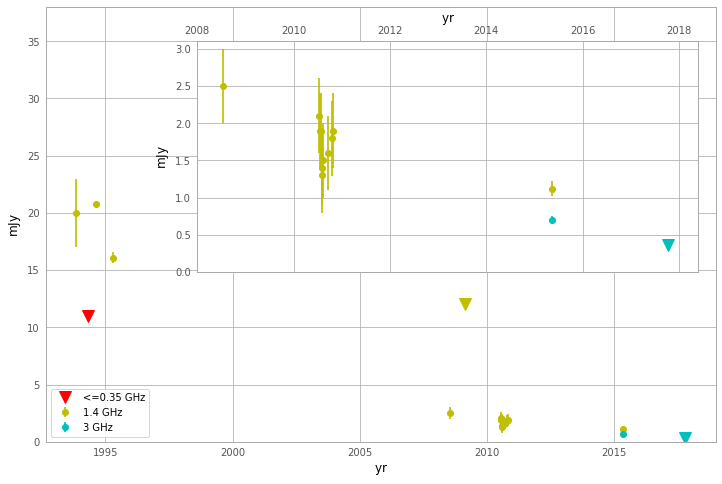

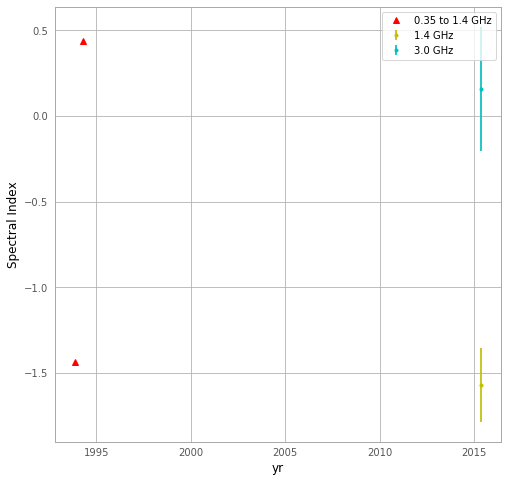

In [20]:
# omit vlssr (not constraining and throws off plot)

with quantity_support():
    fig = plt.figure(figsize=(12,8))
    # fluxes
    plt.plot([t_tgss, t_wenss, t_ab6860]*u.year,
                 [s_tgss, s_wenss, s_ab6860P]*u.milliJansky,
                 'rv', markersize=12, label="<=0.35 GHz")  # 150 MHz
    plt.errorbar([t_ab6860, t_first, t_nvss, t_farnes]*u.year,
                 [s_ab6860, s_first, s_nvss, s_farnesL]*u.milliJansky,
                 markersize=12,
                 yerr=[es_ab6860, es_first, es_nvss, es_farnesL]*u.milliJansky, fmt='y.',
                 label="1.4 GHz")  # 1.4 GHz
    plt.plot(t_ata, s_ata*u.milliJansky, 'yv', markersize=12)  # 3 GHz
    plt.errorbar(t_atlas*u.year, s_atlas*u.milliJansky, yerr=es_atlas*u.milliJansky, markersize=12, fmt='y.')
    plt.errorbar([t_farnes]*u.year,
                 [s_farnesS]*u.milliJansky,
                 yerr=[es_farnesS]*u.milliJansky, fmt='c.', markersize=12,
                 label="3 GHz")  # 3 GHz
    plt.plot([t_vlass]*u.year, [s_vlass]*u.milliJansky, 'cv', markersize=12)  # 3 GHz
    plt.legend(loc=3)
    plt.ylim(0, 38)
    
    left, bottom, width, height = [0.3, 0.42, 0.58, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.plot([t_tgss, t_wenss, t_ab6860]*u.year,
                 [s_tgss, s_wenss, s_ab6860P]*u.milliJansky,
                 'rv', markersize=12, label="<=0.35 GHz")  # 150 MHz
    ax2.errorbar([t_ab6860, t_first, t_nvss, t_farnes]*u.year,
                 [s_ab6860, s_first, s_nvss, s_farnesL]*u.milliJansky,
                 markersize=12, yerr=[es_ab6860, es_first, es_nvss, es_farnesL]*u.milliJansky, fmt='y.',
                 label="1.4 GHz")  # 1.4 GHz
    ax2.errorbar(t_atlas*u.year, s_atlas*u.milliJansky, yerr=es_atlas*u.milliJansky, markersize=12, fmt='y.')
    ax2.errorbar([t_farnes]*u.year,
                 [s_farnesS]*u.milliJansky,
                 yerr=[es_farnesS]*u.milliJansky, markersize=12, fmt='c.',
                 label="3 GHz")  # 3 GHz
    ax2.plot([t_vlass]*u.year, [s_vlass]*u.milliJansky, 'cv', markersize=12)  # 3 GHz
    ax2.set_xlim(2008, 2018.4)
    ax2.set_ylim(0, 3.1)
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top') 
    plt.savefig("fluxlc_j1419.pdf", format="pdf")
    
    plt.figure(figsize=(8,8))
#    plt.subplot(122)
    # alphas
    plt.plot([t_ab6860, t_wenss], [alpha_ab6860, alpha_fw], 'r^', label="0.35 to 1.4 GHz")
    plt.errorbar([t_farnes], [alpha_farnesLL], yerr=[ealpha_farnesLL], fmt='y.', label="1.4 GHz")
    plt.errorbar([t_farnes], [alpha_farnesSS], yerr=[ealpha_farnesSS], fmt='c.', label="3.0 GHz")
    plt.xlabel("yr")
    plt.ylabel("Spectral Index")
    plt.legend()
    plt.savefig("alphalc_j1419.pdf", format="pdf")

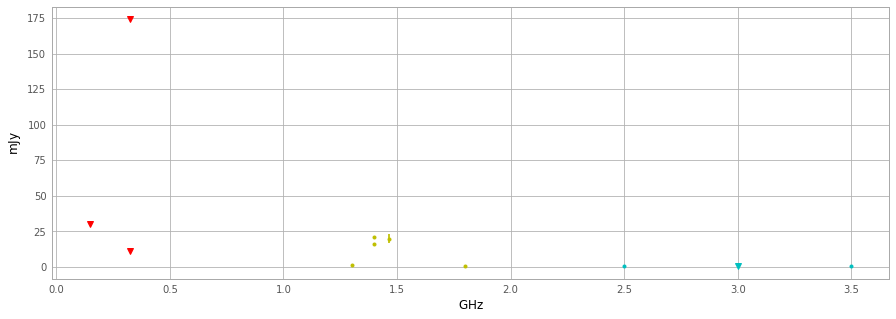

In [21]:
with quantity_support():
    plt.figure(figsize=(15,5))
    plt.errorbar([f_ab6860, f_first, f_nvss, f_farnesL_bottom, f_farnesL_top]*u.GHz,
                 [s_ab6860, s_first, s_nvss, s_farnesL_bottom, s_farnesL_top]*u.milliJansky,
                 yerr=[es_ab6860, es_first, es_nvss, es_farnesL_bottom, es_farnesL_top]*u.milliJansky, fmt='y.')  # 1.4 GHz
    plt.errorbar([f_farnesS_bottom, f_farnesS_top]*u.GHz,
                 [s_farnesS_bottom, s_farnesS_top]*u.milliJansky,
                 yerr=[es_farnesS_bottom, es_farnesS_top]*u.milliJansky, fmt='c.')  # 3 GHz
    plt.plot([f_vlass]*u.GHz, [s_vlass]*u.milliJansky, 'cv')  # 3 GHz
    plt.plot([f_tgss, f_wenss, f_ab6860P]*u.GHz, [s_tgss, s_wenss, s_ab6860P]*u.milliJansky, 'rv')  # low freqs

## Radio supernova modeling

It is really luminous

In [22]:
co = cosmo.Planck15
d_lum = co.luminosity_distance(0.01957)
lum_minL = (s_first*1e-3)*1e-23 * 4*np.pi*d_lum.to_value(u.cm)**2
lum_farnesL = (s_farnesL*1e-3)*1e-23 * 4*np.pi*d_lum.to_value(u.cm)**2
nulnu_min = lum_minL*f_first*1e9
nulnu_farnesL = lum_farnesL*f_farnesL*1e9
print("*Minimum* radio luminosity: L={0} erg/s/Hz, nuLnu = {1} erg/s (nuLnu_Farnes = {2} erg/s)"
      .format(lum_minL, nulnu_min, nulnu_farnesL))


*Minimum* radio luminosity: L=1.9202171679269813e+29 erg/s/Hz, nuLnu = 2.6883040350977737e+38 erg/s (nuLnu_Farnes = 1.5738939367736606e+37 erg/s)


In [35]:
getlum = lambda sjy: sjy*1e-23 * 4 * np.pi * co.luminosity_distance(0.01957).to_value(u.cm)**2

In [23]:
def lc_fong(fp, t0, tdec, p=2.4):
    """ Lightcurve as in Fong et al (2018).
    Short GRB from NS-NS merger.
    https://arxiv.org/pdf/1607.00416.pdf
    """

    timearr = np.linspace(t_ab6860, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    # early evolution
    t1 = np.where(timearr-t0 < tdec)
    fluxarr[t1] = fp*((timearr[t1]-t0)/tdec)**3

    # late evolution
    t2 = np.where(timearr-t0 >= tdec)
    fluxarr[t2] = fp*((timearr[t2]-t0)/tdec)**-((15*p-21)/10)

    return timearr, fluxarr

def lc_margalit(D, nu, t0):
    """ Decaying lightcurve of magnetar powered supernova
    Referenced to FRB 121102 persistent source.
    D in Gpc, nu in GHz, t in yrs.
    assumes alpha=0 and vej=1e9, t_repeater = 30
    """
    
    timearr = np.linspace(t_ab6860, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    fluxarr = 240e-6 * D**(-2) * (nu/10)**(1/3) * (30/(timearr-t0))
    
    return timearr, fluxarr

def lc_plaw(f0, t0, alpha):
    """ General powerlaw lightcurve
    """

    timearr = np.linspace(t_ab6860, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    fluxarr = f0 * (timearr - t0)**alpha
    return timearr, fluxarr

def lc_exp(f0, t0, dt):
    """ General powerlaw lightcurve
    """

    timearr = np.linspace(t_ab6860, t_vlass, 100)
    fluxarr = np.zeros_like(timearr)

    fluxarr = f0 * np.exp(-(timearr - t0)/dt)
    return timearr, fluxarr

In [78]:
# explosion time
t0 = t_ab6860-2

In [100]:
lgrb0 = pd.read_table("model_lgrb_vla0d80.txt", sep='  ', comment='#', names=['days', 'flux', 'flux_forward'])

t_lgrb0 = lgrb0.days
s_lgrb0 = lgrb0.flux*1.5e3*3

lgrb1 = pd.read_table("model_lgrb_vla1d57.txt", sep='  ', comment='#', names=['days', 'flux', 'flux_forward'])

t_lgrb1 = lgrb1.days
s_lgrb1 = lgrb1.flux*1.5e3*3

/Users/caseyjlaw/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/Users/caseyjlaw/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [101]:
names = "time  1.00E+09  3.30E+09  1.00E+10  3.30E+10  1.00E+11  3.30E+11  1.00E+12  3.30E+12  1.00E+13  3.30E+13  1.00E+14  3.30E+14  4.56E+14  1.00E+15  3.30E+15  1.00E+16  3.30E+16  1.00E+17  3.30E+17  1.00E+18".split("  ")
lgrb_fwd = pd.read_table("model_lgrb_onfwd.txt", sep=' ', comment='#', names=names)
lgrb_ctr = pd.read_table("model_lgrb_onctr.txt", sep=' ', comment='#', names=names)
lgrb_ctr.head()

,time,1.00E+09,3.30E+09,1.00E+10,3.30E+10,1.00E+11,3.30E+11,1.00E+12,3.30E+12,1.00E+13,...,1.00E+14,3.30E+14,4.56E+14,1.00E+15,3.30E+15,1.00E+16,3.30E+16,1.00E+17,3.30E+17,1.00E+18
0,2160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19540.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
t_lgrb_on = lgrb_fwd.time/(24*3600)
s_lgrb_on = 1.5e3 * (lgrb_fwd['1.00E+09'] + lgrb_ctr['1.00E+09']) / 1e-23 * u.Jansky

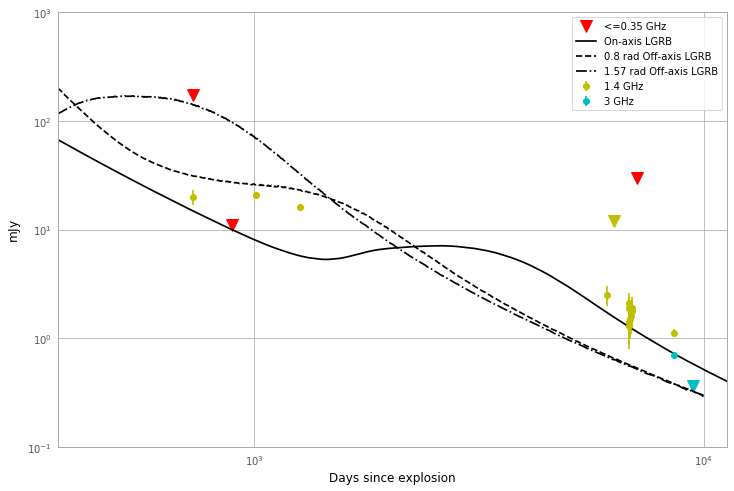

In [107]:
with quantity_support():
    fig = plt.figure(figsize=(12,8))
    # fluxes
    plt.plot(([t_tgss-t0, t_wenss-t0, t_ab6860-t0]*u.year).to_value(u.day),
                 [s_tgss, s_wenss, s_ab6860P]*u.milliJansky,
                 'rv', markersize=12, label="<=0.35 GHz")  # 150 MHz
    plt.errorbar(([t_ab6860-t0, t_first-t0, t_nvss-t0, t_farnes-t0]*u.year).to_value(u.day),
                 [s_ab6860, s_first, s_nvss, s_farnesL]*u.milliJansky,
                 markersize=12,
                 yerr=[es_ab6860, es_first, es_nvss, es_farnesL]*u.milliJansky, fmt='y.',
                 label="1.4 GHz")  # 1.4 GHz
    plt.plot((t_ata*u.year-t0*u.year).to_value(u.day), s_ata*u.milliJansky, 'yv', markersize=12)  # 3 GHz
    plt.errorbar(((t_atlas*u.year) - t0*u.year).to_value(u.day), s_atlas*u.milliJansky, yerr=es_atlas*u.milliJansky, markersize=12, fmt='y.')
    plt.errorbar(([t_farnes-t0]*u.year).to_value(u.day),
                 [s_farnesS]*u.milliJansky,
                 yerr=[es_farnesS]*u.milliJansky, fmt='c.', markersize=12,
                 label="3 GHz")  # 3 GHz
    plt.plot(([t_vlass-t0]*u.year).to_value(u.day), [s_vlass]*u.milliJansky, 'cv', markersize=12)  # 3 GHz
    plt.plot(t_lgrb_on*u.day, s_lgrb_on, 'k', label="On-axis LGRB")
    plt.plot(t_lgrb0*u.day, s_lgrb0, 'k--', label="0.8 rad Off-axis LGRB")
    plt.plot(t_lgrb1*u.day, s_lgrb1, 'k-.', label="1.57 rad Off-axis LGRB")
    plt.loglog()
    plt.legend()
    plt.xlabel("Days since explosion")
    plt.xlim((t_ab6860-t0-1)*365.24, (t_vlass-t0+5)*365.24)
    plt.ylim(1e-1, 1e3)
    plt.savefig("models_j1419.pdf", format="pdf")

#### Luminosity and time scale consistent with GRB or even more energetic phenomenon!

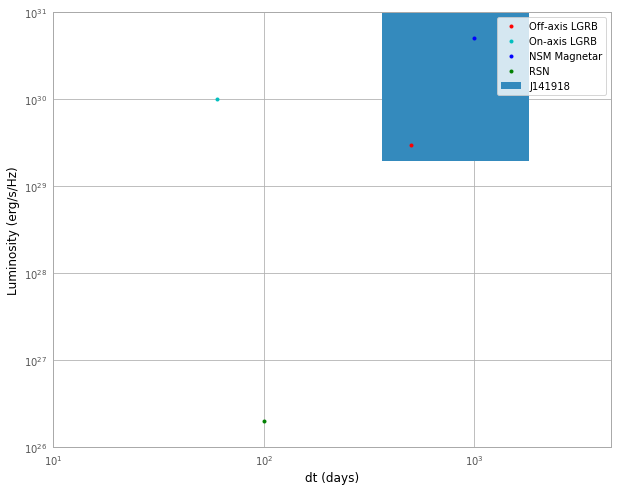

In [29]:
# playing with Metzger et al (2015) plot

fig = plt.figure(figsize=(10,8))
plt.plot(500, 3e29, 'r.', label="Off-axis LGRB")
plt.plot(60, 1e30, 'c.', label="On-axis LGRB")
plt.plot(1000, 5e30, 'b.', label="NSM Magnetar")
plt.plot(100, 2e26, 'g.', label="RSN")
plt.fill_between(np.arange(365, 5*365, 10), lum_minL, 1e31, label="J141918")
plt.xlim(10, 4500)
plt.ylim(1e26, 1e31)
plt.loglog()
plt.xlabel("dt (days)")
plt.ylabel("Luminosity (erg/s/Hz)")
plt.legend()
plt.savefig("ldt_j1419.pdf", format="pdf")

## BATSE
Search of heasarc prior to earliest radio measurement plausible association. Of course, a radio signal can be seen without an GRB, so need to consider chance coincidence more carefully.

An LGRB:
* trigger 927, GRB 911024
* RA=13 54.6 Dec=+38 22
* Time=1991-10-24
* Error radius 4.13 deg and offset=5 deg

More info:
* https://heasarc.gsfc.nasa.gov/FTP/compton/data/batse/trigger/00801_01000/00927_burst/
* https://heasarc.gsfc.nasa.gov/docs/cgro/batse/BATSE_Ctlg/html/927.html

## Next steps

* ~~Analyze more VLA data to fill in lightcurve (esp at L band)~~
* Lightcurve modeling with spectral dependence
* ~~Include models for other kinds of afterglows (or more general model?)~~
* ~~Constrain L vs dt space to classify on Metzger plot~~
* Consider rates: Ofek catalog is complete over what volume? (0.1*L_FRB121102 limit and SDSS limit)

## References

* Brunthaler et al radio discovery of SN in M82: https://arxiv.org/pdf/0904.2388.pdf
* Metzger, Williams and Berger on rates and lightcurves of radio transients: https://arxiv.org/pdf/1502.01350.pdf
* Fong et al on sGRB radio afterglows: https://arxiv.org/pdf/1502.01350.pdf
* Margalit et al on magnetar unification: https://arxiv.org/pdf/1806.05690.pdf